In [2]:
import copy
import random
import math
import numpy as np

import copy
import random

def evaluate(battery_swap_schedule):
    total_travel_time = 0
    total_waiting_time = 0
    battery_urgency_score = 0
    active_fleet_batery_score = 0
    total_battery_cycle = 0
    # for i in range(len(battery_swap_schedule)):
    #     if battery_swap_schedule[i]["assigned"]:
    #         total_travel_time += battery_swap_schedule[i]["travel_time"]
    #         total_waiting_time += battery_swap_schedule[i]["waiting_time"]
    #         battery_urgency_score += ((100 - battery_swap_schedule[i]["exchanged_battery"]) ** 2)
    #         active_fleet_batery_score += (battery_swap_schedule[i]["received_battery"] ** 2)
    #     else:
    #         active_fleet_batery_score += battery_swap_schedule[i]["battery_now"]
    for ev_id, sched in battery_swap_schedule.items():
        if sched and sched.get("assigned"):
            total_travel_time += sched["travel_time"]
            total_waiting_time += sched["waiting_time"]
            battery_urgency_score += ((100 - sched["exchanged_battery"]) ** 2)
            active_fleet_batery_score += (sched["received_battery"] ** 2)
            total_battery_cycle += sched["received_battery_cycle"]
        elif sched:
            active_fleet_batery_score += sched["battery_now"]
    if total_travel_time or total_waiting_time:
        total_score = (battery_urgency_score + active_fleet_batery_score) / ((total_travel_time + (10 * total_waiting_time))/60 + total_battery_cycle/8)
    else:
        total_score = battery_urgency_score + active_fleet_batery_score

    return total_score

def queue_update(solution, ev, battery_swap_station, charging_rate, required_battery_threshold=80):
    slot_timeline = {}
    station_batteries = copy.deepcopy(battery_swap_station)

    swaps = []

    # 1. Masukkan jadwal tetap (dari ev['swap_schedule']) dulu ke slot_timeline
    # Kumpulkan semua jadwal tetap dari ev['swap_schedule']
    temp_queue = {}

    for ev_id, data in ev.items():
        sched = copy.deepcopy(data.get('swap_schedule'))
        if sched and sched.get('assigned'):
            key = (sched['battery_station'], sched['slot'])
            ready_time = sched['travel_time'] + sched['waiting_time']
            exchanged_battery = sched['exchanged_battery']
            exchanged_battery_cycle = sched['battery_cycle']

            if key not in temp_queue:
                temp_queue[key] = [(ready_time, exchanged_battery, exchanged_battery_cycle)]
            else:
                temp_queue[key].append((ready_time, exchanged_battery, exchanged_battery_cycle))

    # Urutkan setiap antrian berdasarkan arrival_time
    slot_timeline = {
        key: sorted(entries, key=lambda x: x[0])
        for key, entries in temp_queue.items()
    }

    # 2. Kumpulkan EV dari solusi yang assigned, tapi hanya yang tidak punya jadwal tetap
    for ev_id, sched in solution.items():
        if sched['assigned'] and not ev[ev_id]['swap_schedule']:
            arrival_time = sched['travel_time']
            key = (sched['battery_station'], sched['slot'])
            swaps.append((arrival_time, ev_id, key))

    # 3. Urutkan berdasarkan arrival_time (yang datang duluan diproses lebih dulu)
    swaps.sort()

    # 4. Proses masing-masing EV, hitung ulang waiting_time dan received_battery
    for _, ev_id, key in swaps:
        sched = solution[ev_id]
        station_idx, slot_idx = key

        if key not in slot_timeline:
            last_ready_time = 0
            last_insert = battery_swap_station[station_idx][slot_idx][0]
            last_insert_cycle = battery_swap_station[station_idx][slot_idx][1]
        else:
            last_ready_time, last_insert, last_insert_cycle = slot_timeline[key][-1]

        arrival_time = sched['travel_time']
        time_to_80 = max(0, (required_battery_threshold - last_insert) / charging_rate)
        ready_time = last_ready_time + time_to_80
        waiting_time = max(0, ready_time - arrival_time)

        exchanged_battery = sched['exchanged_battery']
        received_battery = min(100, last_insert + (arrival_time + waiting_time - last_ready_time) * charging_rate)
        exchanged_battery_cycle = sched['battery_cycle']
        received_battery_cycle = last_insert_cycle + (received_battery - last_insert) / 100

        # Update ke dalam solution
        solution[ev_id]['waiting_time'] = round(waiting_time, 2)
        solution[ev_id]['received_battery'] = round(received_battery, 2)
        solution[ev_id]['received_battery_cycle'] = round(received_battery_cycle, 2)

        # Tambahkan ke slot_timeline untuk update antrian selanjutnya
        if key not in slot_timeline:
            slot_timeline[key] = [(arrival_time + waiting_time, exchanged_battery, exchanged_battery_cycle)]
        else:
            slot_timeline[key].append((arrival_time + waiting_time, exchanged_battery, exchanged_battery_cycle))

    return solution


def random_initialization(battery_swap_station, ev, threshold, charging_rate, required_battery_threshold=80):
    solution = {}
    station_batteries = copy.deepcopy(battery_swap_station)

    # Inisialisasi semua EV yang punya schedule tetap
    for i, data in ev.items():
        if data['swap_schedule']:
            solution[i] = copy.deepcopy(data['swap_schedule'])

    # Ambil EV yang layak dijadwalkan
    candidates = []
    for i, data in ev.items():
        if data['swap_schedule']:
            continue
        energy_to_nearest = min(data['energy_distance'])
        if data['battery_now'] - energy_to_nearest < threshold:
            candidates.append(i)

    # Acak urutan EV
    random.shuffle(candidates)

    # Jadwalkan secara acak ke slot kosong
    slot_keys = [(i, j) for i in range(len(battery_swap_station)) for j in range(len(battery_swap_station[i]))]
    slot_usage = {k: [] for k in slot_keys}

    for i in candidates:
        data = ev[i]
        valid_options = []

        for station_idx, (ed, tt) in enumerate(zip(data['energy_distance'], data['travel_time'])):
            if data['battery_now'] - ed < 0:
                continue
            for slot_idx in range(len(battery_swap_station[station_idx])):
                valid_options.append((station_idx, slot_idx, ed, tt))

        if not valid_options:
            solution[i] = {
                'assigned': False,
                'battery_now': data['battery_now'],
                'battery_cycle': data['battery_cycle'],
                'battery_station': None,
                'slot': None,
                'energy_distance': None,
                'travel_time': None,
                'waiting_time': None,
                'exchanged_battery': None,
                'received_battery': None,
                'received_battery_cycle': None
            }
            continue

        # Pilih slot acak dari opsi valid
        station_idx, slot_idx, energy_dist, travel_time = random.choice(valid_options)
        key = (station_idx, slot_idx)
        exchanged_battery = data['battery_now'] - energy_dist

        solution[i] = {
            'assigned': True,
            'battery_now': data['battery_now'],
            'battery_cycle': data['battery_cycle'],
            'battery_station': station_idx,
            'slot': slot_idx,
            'energy_distance': energy_dist,
            'travel_time': travel_time,
            'waiting_time': 0,  # akan diupdate
            'exchanged_battery': exchanged_battery,
            'received_battery': 0,  # akan diupdate
            'received_battery_cycle': 0 # akan diupdate
        }

    # Update ulang waiting_time dan received_battery
    solution = queue_update(solution, ev, battery_swap_station, charging_rate, required_battery_threshold)
    return solution

def get_neighbor(solution, ev, battery_swap_station, charging_rate, threshold=15, required_battery_threshold=80):
    neighbor = copy.deepcopy(solution)

    # Ambil daftar EV yang assigned di solution tetapi tidak punya swap_schedule tetap di ev
    movable_ev_ids = [
        ev_id for ev_id in neighbor
        if neighbor[ev_id] and neighbor[ev_id].get("assigned") and not ev[ev_id].get("swap_schedule")
    ]

    if not movable_ev_ids:
        return neighbor  # Tidak ada yang bisa diubah

    # Pilih satu EV secara acak dari yang bisa diubah
    ev_id = random.choice(movable_ev_ids)
    data = ev[ev_id]

    # Cari opsi stasiun-slot valid untuk EV ini
    valid_options = []
    for station_idx, (ed, tt) in enumerate(zip(data['energy_distance'], data['travel_time'])):
        if data['battery_now'] - ed < 0:
            continue
        for slot_idx in range(len(battery_swap_station[station_idx])):
            valid_options.append((station_idx, slot_idx, ed, tt))

    if not valid_options:
        # Jika tidak ada opsi valid, set jadi unassigned
        neighbor[ev_id] = {
            'assigned': False,
            'battery_now': data['battery_now'],
            'battery_cycle': data['battery_cycle'],
            'battery_station': None,
            'slot': None,
            'energy_distance': None,
            'travel_time': None,
            'waiting_time': None,
            'exchanged_battery': None,
            'received_battery': None,
            'received_battery_cycle': None
        }
    else:
        # Acak salah satu pilihan valid
        station_idx, slot_idx, energy_dist, travel_time = random.choice(valid_options)
        exchanged_battery = data['battery_now'] - energy_dist
        neighbor[ev_id] = {
            'assigned': True,
            'battery_now': data['battery_now'],
            'battery_cycle': data['battery_cycle'],
            'battery_station': station_idx,
            'slot': slot_idx,
            'energy_distance': energy_dist,
            'travel_time': travel_time,
            'waiting_time': 0,  # akan diupdate
            'exchanged_battery': exchanged_battery,
            'received_battery': 0,  # akan diupdate
            'received_battery_cycle': 0 # akan diupdate
        }

    # Update ulang nilai waiting_time dan received_battery setelah perubahan
    neighbor = queue_update(neighbor, ev, battery_swap_station, charging_rate, required_battery_threshold)
    return neighbor

In [5]:
import random

def prec_local_search(ref_1, ref_2, ev, battery_swap_station, charging_rate, required_battery_threshold=80):
    solutions = []
    solutions_score = []
    current_solution = copy.deepcopy(ref_1)

    # Cari semua EV yang assignment-nya berbeda dari solusi best/guide
    for ev_id in ref_1:
        if ev[ev_id].get("swap_schedule"):
            continue  # skip yang fix
        ref_1_sched = ref_1[ev_id]
        ref_2_sched = ref_2.get(ev_id)

        # Kalau beda lokasi atau slot, lakukan relinking
        if ref_2_sched and ref_1_sched["assigned"] and ref_2_sched["assigned"]:
            if (ref_1_sched["battery_station"] != ref_2_sched["battery_station"] or
                ref_1_sched["slot"] != ref_2_sched["slot"]):

                # Ubah menuju assignment guide
                current_solution[ev_id]["battery_station"] = ref_2_sched["battery_station"]
                current_solution[ev_id]["slot"] = ref_2_sched["slot"]
                current_solution[ev_id]["energy_distance"] = ev[ev_id]["energy_distance"][ref_2_sched["battery_station"]]
                current_solution[ev_id]["travel_time"] = ev[ev_id]["travel_time"][ref_2_sched["battery_station"]]
                current_solution[ev_id]["exchanged_battery"] = (
                    current_solution[ev_id]["battery_now"] - current_solution[ev_id]["energy_distance"]
                )

                # Update queue
                current_solution = queue_update(current_solution, ev, battery_swap_station, charging_rate, required_battery_threshold)
                current_solution_score = evaluate(current_solution)
                
                solutions.append(current_solution)
                solutions_score.append(current_solution_score)

    # Gabungkan solusi dan skor, lalu urutkan dari yang terbaik
    sorted_solutions = sorted(zip(solutions, solutions_score), key=lambda x: x[1], reverse=True)

    # Ambil maksimal 10 solusi terbaik
    top_solutions = sorted_solutions[:10]

    # Pisahkan kembali menjadi dua list jika diperlukan
    top_solutions_only = [sol for sol, score in top_solutions]
    top_scores_only = [score for sol, score in top_solutions]

    if top_solutions_only:
        selected_solution = random.choice(top_solutions_only)
    else:
        selected_solution = None
        return ref_1, evaluate(ref_1)

    ev_ids = [eid for eid in selected_solution if selected_solution[eid]["assigned"]]
    if len(ev_ids) < 2:
        return ref_1, evaluate(ref_1)  # tidak cukup untuk membuat chain

    # Ambil 10 EV random untuk shift
    chain = random.sample(ev_ids, min(10, len(ev_ids)))
    new_solution = copy.deepcopy(selected_solution)

    # Simpan posisi awal (yang akan dipakai di akhir)
    first_station = selected_solution[chain[0]]["battery_station"]
    first_slot = selected_solution[chain[0]]["slot"]

    # Shift EV i ke posisi EV i-1
    for i in range(1, len(chain)):
        from_id = chain[i]
        to_id = chain[i - 1]
        new_solution[to_id]["battery_station"] = selected_solution[from_id]["battery_station"]
        new_solution[to_id]["slot"] = selected_solution[from_id]["slot"]

    # EV terakhir ambil posisi EV pertama
    new_solution[chain[-1]]["battery_station"] = first_station
    new_solution[chain[-1]]["slot"] = first_slot

    # Update field energi dan waktu
    for ev_id in chain:
        station = new_solution[ev_id]["battery_station"]
        new_solution[ev_id]["energy_distance"] = ev[ev_id]["energy_distance"][station]
        new_solution[ev_id]["travel_time"] = ev[ev_id]["travel_time"][station]
        new_solution[ev_id]["exchanged_battery"] = (
            new_solution[ev_id]["battery_now"] - new_solution[ev_id]["energy_distance"]
        )
    
    if evaluate(new_solution) > evaluate(selected_solution):
        return new_solution, evaluate(new_solution)
    else:
        return selected_solution, evaluate(selected_solution)

def prec_ev_optimization(
    battery_swap_station,
    ev,
    threshold,
    charging_rate,
    required_battery_threshold=80,
    max_iter=200
):
    reference_1 = random_initialization(battery_swap_station, ev, threshold, charging_rate, required_battery_threshold)
    reference_2 = random_initialization(battery_swap_station, ev, threshold, charging_rate, required_battery_threshold)
    
    if evaluate(reference_1) > evaluate(reference_2):
        best = copy.deepcopy(reference_1)
        best_score = evaluate(reference_1)
        reference_1 = copy.deepcopy(reference_2)
        reference_2 = copy.deepcopy(best)
    else:
        best = copy.deepcopy(reference_2)
        best_score = evaluate(reference_2)

    for _ in range(max_iter):
        new_solution, new_solution_score = prec_local_search(reference_1, reference_2, ev, battery_swap_station, charging_rate, required_battery_threshold)

        if new_solution_score > evaluate(reference_1):
            if new_solution_score > evaluate(reference_2):
                reference_1 = copy.deepcopy(reference_2)
                reference_2 = copy.deepcopy(new_solution)
                best = copy.deepcopy(new_solution)
                best_score = copy.deepcopy(new_solution_score)
            else:
                if new_solution != reference_2:
                    reference_1 = copy.deepcopy(new_solution)

        print(best_score)

    return best, best_score



In [7]:
import pickle

# Load dataset pickle
with open("ev_battery_swap_random_dataset.pkl", "rb") as f:
    battery_swap_station_demo, ev_demo = pickle.load(f)

# Jalankan PREC
solution, score = prec_ev_optimization(
    battery_swap_station=battery_swap_station_demo,
    ev=ev_demo,
    threshold=15,
    charging_rate=100 / 240,
    required_battery_threshold=80,
    max_iter=100
)

print("Best PREC EV Scheduling Score:", score)


180.78299907947581
188.00212579839868
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079675542815
188.0079

In [8]:
import time
import numpy as np
import matplotlib.pyplot as plt


def plot_distributions_2(initial_temp=100, num_of_cycle=100, runs=1000, max_attempts=1000):
    """
    Run the Simulated Annealing algorithm multiple times and plot distributions of 
    both fitness values and computation times.
    
    Parameters:
    - initial_temp: Initial temperature
    - num_of_cycle: Number of cycles after which temperature becomes 0
    - runs: Number of independent runs
    - max_attempts: Maximum number of attempts to find a valid solution
    
    Returns:
    - mean_fitness: Mean fitness across all valid runs
    - std_fitness: Standard deviation of fitness across all valid runs
    - mean_duration: Mean computation time across all runs (in seconds)
    - std_duration: Standard deviation of computation time across all runs (in seconds)
    """
    fitness_values = []
    duration_values = []
    valid_runs = 0
    
    print(f"Running {runs} trials of improved PREC...")
    
    for i in range(runs):
        if i % 100 == 0 and i > 0:
            print(f"Completed {i} runs...")
            
        start_time = time.time()

        solution, fitness = prec_ev_optimization(
            battery_swap_station=battery_swap_station_demo,
            ev=ev_demo,
            threshold=15,
            charging_rate=100 / 240,
            required_battery_threshold=80,
            max_iter=100
        )
                
        end_time = time.time()
        duration = end_time - start_time
        duration_values.append(duration)
        
        if solution is not None and fitness is not None:
            fitness_values.append(fitness)
            valid_runs += 1
    
    # Print summary
    print(f"Valid solutions: {valid_runs}/{runs} ({valid_runs/runs*100:.2f}%)")
    
    # 1. PLOT FITNESS DISTRIBUTION
    if fitness_values:
        # Calculate fitness statistics
        mean_fitness = np.mean(fitness_values)
        std_fitness = np.std(fitness_values)
        
        # Plot fitness distribution
        plt.figure(figsize=(8, 6))
        plt.hist(fitness_values, bins=20, edgecolor='black')
        plt.axvline(mean_fitness, linestyle='--', label=f'Mean = {mean_fitness:.2f}')
        plt.axvline(mean_fitness + std_fitness, color='gray', linestyle=':', 
                    label=f'+1 Std = {std_fitness:.2f}')
        plt.axvline(mean_fitness - std_fitness, color='gray', linestyle=':', 
                    label=f'-1 Std = {std_fitness:.2f}')
        plt.title('Distribution of Best Fitness over {} Runs'.format(valid_runs))
        plt.xlabel('Fitness')
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print(f"Mean fitness: {mean_fitness:.4f}")
        print(f"Std deviation of fitness: {std_fitness:.4f}")
    else:
        mean_fitness = None
        std_fitness = None
        print("No valid solutions found to plot fitness distribution")
    
    # 2. PLOT DURATION DISTRIBUTION
    if duration_values:
        # Calculate duration statistics
        mean_duration = np.mean(duration_values)
        std_duration = np.std(duration_values)
        
        # Plot duration distribution
        plt.figure(figsize=(8, 6))
        plt.hist(duration_values, bins=20, edgecolor='black')
        plt.axvline(mean_duration, linestyle='--', label=f'Mean = {mean_duration:.4f}s')
        plt.axvline(mean_duration + std_duration, color='gray', linestyle=':', 
                    label=f'+1 Std = {std_duration:.4f}s')
        plt.axvline(mean_duration - std_duration, color='gray', linestyle=':', 
                    label=f'-1 Std = {std_duration:.4f}s')
        plt.title('Distribution of Computation Time over {} Runs'.format(runs))
        plt.xlabel('Time (seconds)')
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print(f"Mean computation time: {mean_duration:.4f} seconds")
        print(f"Std deviation of time: {std_duration:.4f} seconds")
    else:
        mean_duration = None
        std_duration = None
        print("No runs completed to plot duration distribution")
    
    return mean_fitness, std_fitness, mean_duration, std_duration


Running 100 trials of improved PREC...
172.85353861520844
172.85353861520844
173.082799227285
173.082799227285
173.4399359339022
173.4399359339022
173.4399359339022
173.4399359339022
173.4399359339022
173.4399359339022
173.4399359339022
173.4399359339022
173.4399359339022
173.4399359339022
173.4399359339022
173.4399359339022
173.4399359339022
173.4399359339022
173.4399359339022
173.4399359339022
173.4399359339022
173.4399359339022
173.4399359339022
173.4399359339022
173.89605047105337
173.89605047105337
173.89605047105337
174.22550832360773
174.22550832360773
174.22550832360773
174.22550832360773
174.22550832360773
174.22550832360773
174.22550832360773
174.22550832360773
174.22550832360773
174.22550832360773
174.22550832360773
174.22550832360773
174.22550832360773
174.22550832360773
174.22550832360773
174.22550832360773
174.22550832360773
174.22550832360773
174.22550832360773
174.22550832360773
174.22550832360773
174.22550832360773
174.22550832360773
174.22550832360773
174.225508323607

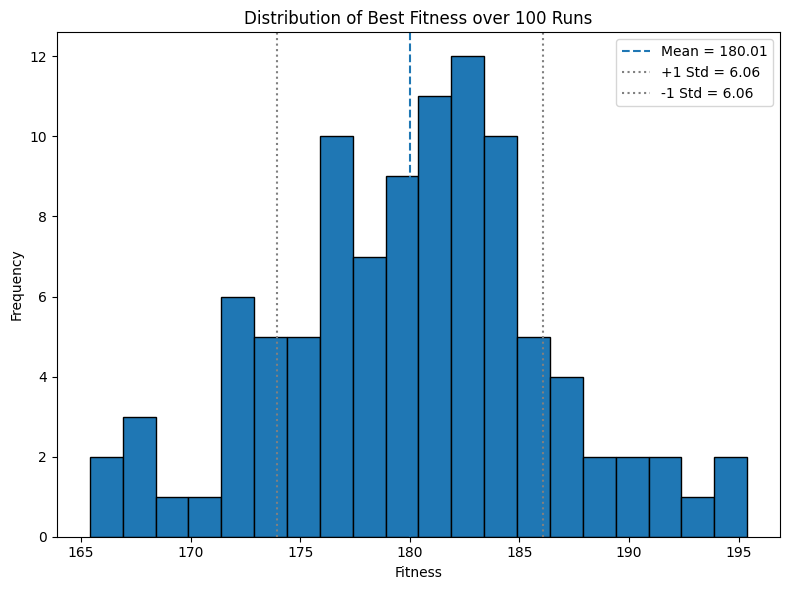

Mean fitness: 180.0140
Std deviation of fitness: 6.0636


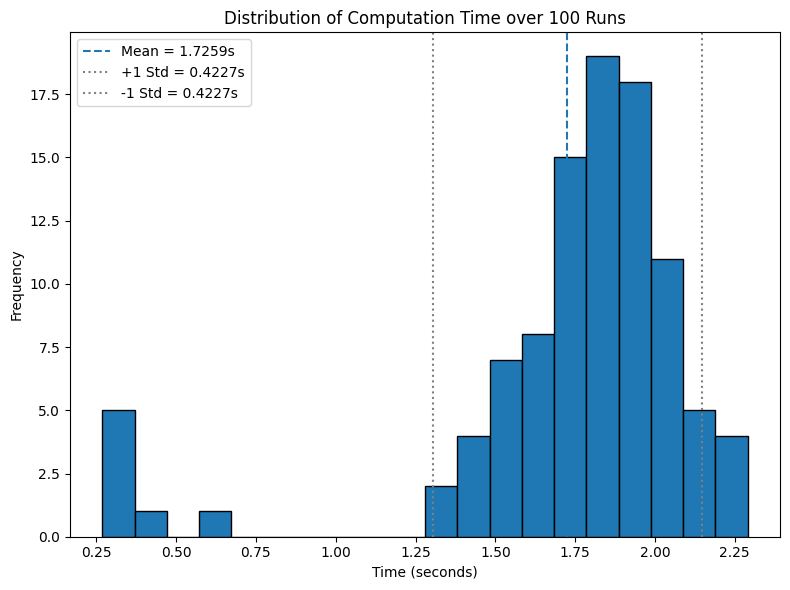

Mean computation time: 1.7259 seconds
Std deviation of time: 0.4227 seconds


(np.float64(180.0139839205563),
 np.float64(6.063629348101861),
 np.float64(1.7259262537956237),
 np.float64(0.4227425220823946))

In [9]:
plot_distributions_2(initial_temp=100, num_of_cycle=300, runs=100, max_attempts=10)

In [ ]:
orders_per_minute = np.random.poisson(lam=16.67)

In [ ]:
print(orders_per_minute)

25
